# Carbon depletion

Exploring the impact of carbon depletion on the composition of discs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-talk')

%matplotlib inline


### Define a few basic compositions

For the baseline composition we will follow Oberg & Wordsworth (2019). The assumptions are:
 - Oyxgen is divided amongst silicates, H2O, CO and CO2 according to 2:2:1:1 
 - The remaining carbon is split 3:1 amongst refractory C and volatile C (ethane)
 - Nitrogen is 90% in N2, 10% in NH3
 - Sulfur and phosphorous are fully refractory composition.
 - Noble gases are in atomic form

Note this results in an over-estimate of the Fe and Si abundances by 25-30%.


In [2]:
from drift_composition.atoms import (
    load_protosolar_abundances,
    atoms_in_molecule, molecule_mass
)

atom_abund = load_protosolar_abundances()

# Oxygen / Nitrogen / Noble gases
mol_abund = {
    'H2O' : atom_abund['O'] / 3,
    'CO'  : atom_abund['O'] / 6,
    'CO2' : atom_abund['O'] / 12,
    
    'N2'  : atom_abund['N'] * 0.45,
    'NH3' : atom_abund['N'] * 0.1,

    #'He' : atom_abund['He'], 
    'Ar' : atom_abund['Ar'], 
    'Kr' : 1.8e-9,
    'Xe' : 1.7e-10,
}
grain_abund = {
    'MgFeSiO4' : atom_abund['O'] / 12,
    'P'  : atom_abund['P'],
    'S'  : atom_abund['S'],
    'Na' : atom_abund['Na'],
    'K'  : atom_abund['K'],
}

# Count up the total carbon/oxygen abundance
Ctot = 0
Otot = 0
for mol in mol_abund:
    atoms = atoms_in_molecule(mol)
    if 'C' in atoms:
        Ctot += mol_abund[mol] * atoms['C']
    if 'O' in atoms:
        Otot += mol_abund[mol] * atoms['O']


for mol in grain_abund:
    atoms = atoms_in_molecule(mol)
    if 'C' in atoms:
        Ctot += grain_abund[mol] * atoms['C']     
    if 'O' in atoms:
        Otot += grain_abund[mol] * atoms['O']

# Put the rest into ethane / refractory carbon:
C_org = atom_abund['C'] - Ctot 
mol_abund['C2H6'] = C_org * 0.25 / 2 
mol_abund['C4H10'] = C_org * 0.75 / 4


print(grain_abund['MgFeSiO4']/atom_abund['Mg'])
print(grain_abund['MgFeSiO4']/atom_abund['Fe'])
print(grain_abund['MgFeSiO4']/atom_abund['Si'])
print(Otot/atom_abund['O'], atom_abund['O'])
print(atom_abund['Si'],atom_abund['H'],atom_abund['He'])
None

1.0252239756769865
1.2906805157604024
1.2613010403635088
1.0 0.0004897074374427338
3.235464953590034e-05 0.9118779199902495 0.08708366529473373


### Estimate bulk physical parameters from the composition

In [3]:
# Neglect metals and assume H is in H2 since this is used internally in the code
mean_mol_wgt = (atom_abund['H'] + 4*atom_abund['He']) /  (0.5*atom_abund['H'] + atom_abund['He'])

def dust_to_gas_ratio(dust_abund):
    m_tot = 0
    m_dust = 0
    for atom in atom_abund:
        m_tot += molecule_mass(atom) * atom_abund[atom]

    for mol in dust_abund:
        m_dust += molecule_mass(mol) * dust_abund[mol]

    return m_dust / m_tot

dust_to_gas = dust_to_gas_ratio(grain_abund)

print(f'Mean molecular weight: {mean_mol_wgt}')
print(f'Dust to gas ratio: {dust_to_gas}')

Mean molecular weight: 2.3207367842113378
Dust to gas ratio: 0.005861683003426774


### Create compositions with suitable carbon depletion

In [4]:
def deplete_CO_abundance(abund, fraction, species):
    """Convert a given fraction of CO into a different species. Any 
    excess/deficit of oxygen is assumed to change the water abundance"""
    if not (0 < fraction < 1):
        raise ValueError(f"Fraction of CO removed must be between 0 and 1, not {fraction}.")

    # Copy the abundances
    new = {}
    for mol in abund:
        new[mol] = abund[mol]
    if species not in new:
        new[species] = 0
    
    # Deplete CO
    xi = abund['CO'] * fraction
    new['CO'] -= xi

    # Update the abundance of the new species and H2O depending on the
    # number of carbon and oxygen atoms in the molecule.
    spec_abund =  atoms_in_molecule(species)

    new[species] += xi / spec_abund['C']
    new['H2O'] -= xi*(spec_abund['O']/spec_abund['C'] - 1)

    return new

def get_species_info(abund):
    """Load the molecular properties for the given abundances"""
    # Load the properties of the molecules
    species, _ = get_molecular_properties()
    s_map = { s.name : s for s in species}

    s_inc, abund_arr = [], []
    for mol in abund:
        s_inc.append(s_map[mol])
        abund_arr.append(abund[mol] / atom_abund['H'])

    return s_inc, np.array(abund_arr)

def create_temperature_profile(grid, Lstar, Mdot_gas, alpha, 
                               kappa=1, gamma=10, phi=0.05, Mstar=1, Tmax=1300):
    """Estimate an irridiated and viscously heated temperature profile given the
    accretion rate, viscous alpha and Rosseland-mean opacity (per unit gas) mass"""

    from scipy.interpolate import PchipInterpolator
    from drift_composition.constants import (
        stefan_boltzmann, G_Msun, Msun, Lsun, yr
    )

    class T_Profile:
        def __init__(self, grid, tauZ, Lstar, Mdot, Mstar, gamma, phi, Tmax):
            
            # Interpolate the vertical optical depth:
            self._interp = PchipInterpolator(np.log(grid.Rc), np.log(tauZ))

            self._Lstar = Lstar
            self._Mstar = Mstar
            self._Mdot = Mdot

            self._gamma = gamma
            self._phi = phi

            self._Tmax = Tmax


        def tau(self, R):
            return np.exp(self._interp(np.log(R)))

        def Tirr4(self, R):
            return self._Lstar*Lsun / (4*np.pi*R*R * stefan_boltzmann)

        def Tint4(self, R):
            Omk2 = G_Msun * self._Mstar / R**3
            return (3/(8*np.pi)) * self._Mdot*Msun/yr * Omk2 / stefan_boltzmann
            
        def __call__(self, R):
            tau = self.tau(R)
            f_visc = (2/3 + tau) 

            fac = np.exp(-self._gamma*tau/self._phi)
            fac1 = -np.expm1(-self._gamma*tau/self._phi)

            f_irr = 0.5*self._phi + 3*self._phi**2/self._gamma * fac1 + 0.25*self._gamma*fac
            
            Teq4 = 0.75*self.Tint4(R)*f_visc + 0.75*self.Tirr4(R)*f_irr
            
            # Smooth the temperature limit as the model needs smooth pressure gradients
            return np.power(1/Teq4**2 + 1/self._Tmax**8, -0.125)


    # Use a passive disc as the initial temperature
    T1 = T_Profile(grid, np.full_like(grid.Rc, 1000), Lstar, 0, Mstar, gamma, phi, Tmax)

    # Iterate temperature to convergence.
    for iter in range(100):
        T0 = T1
        DM = DiscModel(grid, Mdot_gas, alpha, T0, mu=mean_mol_wgt)
        tau = DM.Sigma_gas * kappa

        T1 = T_Profile(grid, tau, Lstar, Mdot_gas, Mstar, gamma, phi, Tmax)

        if np.all(np.abs(T1(grid.Rc) - T0(grid.Rc))/np.maximum(T1(grid.Rc), T0(grid.Rc)) < 1e-5):
            break
    else:
        raise ValueError("Temperature iteration failed to converge")

    return T1


def species_label(species):
    if species in ['C4H10']:
        return 'C_grain'
    else:
        return species
    

# The basic chemical picture

The Oberg+ 2011 type picture of a disc with the base abundances

### Define constants describing the disc model

In [5]:
Mdot_gas = 1e-9
dust_flux_factor = 10 
Stokes = lambda R: 0.01

alpha = lambda R: 1e-3

Lstar = 2

In [6]:
from drift_composition.constants import Rau
from drift_composition.grid import Grid
from drift_composition.disc import DiscModel
from drift_composition.molecule import get_molecular_properties

grid = Grid(0.1*Rau, 50*Rau, 512)

T = create_temperature_profile(grid, Lstar, Mdot_gas, alpha)

DM = DiscModel(grid, Mdot_gas, alpha, T, mu=mean_mol_wgt)

DM.compute_dust_surface_density(Mdot_gas*dust_to_gas, lambda R:0)

species, abundances = get_species_info(mol_abund)
DM.compute_chemistry(species, abundances, d2g=dust_to_gas)
mass_dir = dict(zip([spec.name for spec in species],[spec.mass_amu for spec in species]))
print(mass_dir)

{'H2O': 18, 'CO': 28, 'CO2': 44, 'N2': 28, 'NH3': 17, 'Ar': 40, 'Kr': 84, 'Xe': 131, 'C2H6': 30, 'C4H10': 58}


Default planet evolution

In [7]:
from drift_composition.constants import Mearth, Msun
from drift_composition.simple_planet import PlanetEnv, Planet, std_evo_comp
from drift_composition.simple_reduction import Evolution
import drift_composition.simple_graphs as sg

m_star = 1.4 #solar_masses
gas = {'H2':atom_abund['H']/2,'He':atom_abund['He']}
dust = grain_abund
p_env = PlanetEnv(grid, alpha(grid.Rc), mean_mol_wgt, m_star, gas, dust) #create local disc properties

dt = 5000 #length of a timestep in yr
Nt = 2000 #number of timesteps
f_plansi = 1e-2 #fraction of planitesimal/dust

frac_gc = 0.01 #initial gas/core fraction of the planet
init_m  = 5.0  #initial planet mass in M_earth
init_r  = 8.0

#initializing the planets chemical composition
f_comp = dict(zip([spec.name for spec in species],np.zeros((len(species),2))))
for g in gas:
    f_comp[g] = np.zeros(2)
    print(f_comp[g],g)
for d in dust:
    f_comp[d] = np.zeros(2)

planet_ini = Planet(init_m*Mearth/Msun, init_m*(1-frac_gc)*Mearth/Msun, init_m*(frac_gc)*Mearth/Msun, f_comp, init_r*Rau)

planet_evo, nn = std_evo_comp(planet_ini, DM, p_env, T(grid.Rc),f_plansi, dt, Nt)
e = Evolution(planet_evo, nn, dt) #rearrange the data for easy plotting

[0. 0.] H2
[0. 0.] He


Plotting the composition of the disc and the planet

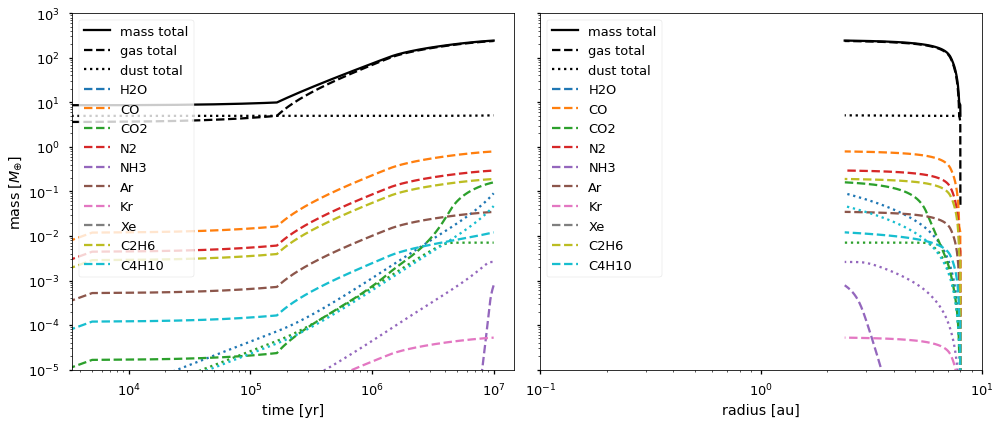

In [8]:
# same as calling sg.plot_planet(evolution)

f, ax = plt.subplots(1,2, figsize=(14, 6), sharey=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax[0].plot(e.time, e.masses*Msun/Mearth, 'k-', label='mass total')
ax[0].plot(e.time, e.mgs*Msun/Mearth, 'k--', label='gas total')
ax[0].plot(e.time, e.mcs*Msun/Mearth, 'k:', label='dust total')
for name, c in zip(list(e.f_comps.keys()),colors):
    ax[0].plot(e.time, e.f_comps[name][0]*Msun/Mearth, '--', c=c, label=name)
    ax[0].plot(e.time, e.f_comps[name][1]*Msun/Mearth, ':', c=c)
ax[0].set_ylim(1e-5,1e3)
ax[0].set_ylabel(r'mass [$M_{\oplus}$]')
ax[0].set_xlabel('time [yr]')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')


ax[1].plot(e.rs, e.masses*Msun/Mearth, 'k-', label='mass total')
ax[1].plot(e.rs, e.mgs*Msun/Mearth, 'k--', label='gas total')
ax[1].plot(e.rs, e.mcs*Msun/Mearth, 'k:', label='dust total')
for name, c in zip(list(e.f_comps.keys()),colors):
    ax[1].plot(e.rs, e.f_comps[name][0]*Msun/Mearth, '--', c=c, label=name)
    ax[1].plot(e.rs, e.f_comps[name][1]*Msun/Mearth, ':', c=c)
ax[1].set_ylim(1e-5,1e3)
ax[1].set_xlim(1e-1,1e1)
ax[1].set_xlabel('radius [au]')
#ax[1].set_ylabel(r'mass [$M_{\oplus}$]')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')
f.tight_layout()


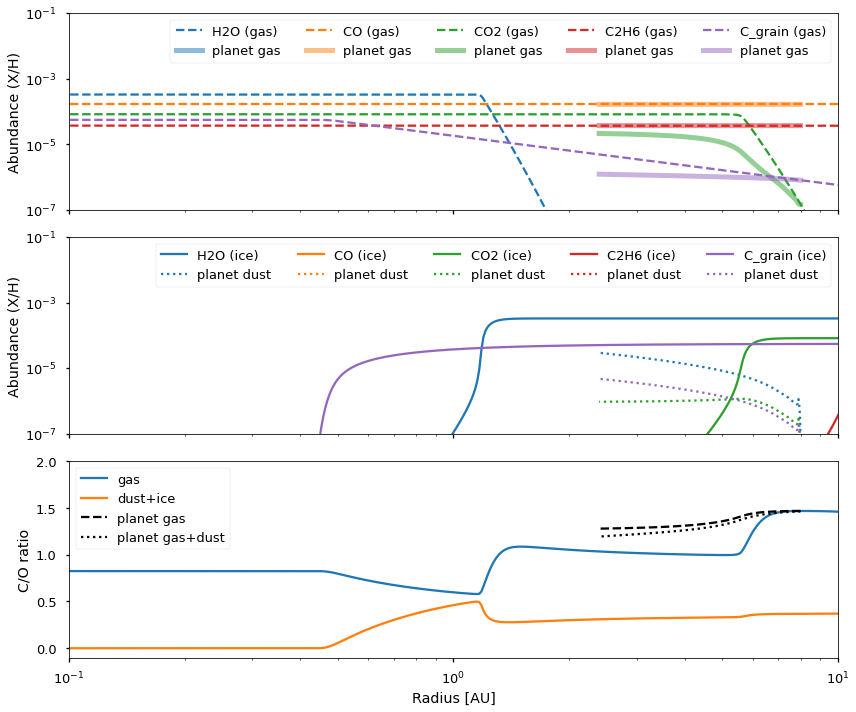

<Figure size 432x288 with 0 Axes>

In [9]:

columns = DM.compute_molecular_column()
f, ax = plt.subplots(3, figsize=(12, 10), sharex=True)

idx = columns['CO'][:,0] > 0.5 * columns['CO'][:,1]

for spec in ['H2O', 'CO', 'CO2', 'C2H6', 'C4H10']:
    l,= ax[0].loglog(grid.Rc/Rau, 0.5*columns[spec][:,0]/columns['H2'][:,0], 
                     label=f'{species_label(spec)} (gas)',  ls='--', )
    ax[1].loglog(grid.Rc/Rau, 0.5*columns[spec][:,1]/columns['H2'][:,0], 
                 label=f'{species_label(spec)} (ice)',c=l.get_color())
    
    ax[0].plot(e.rs[1:], e.f_comps[spec][0][1:]/e.f_comps['H2'][0][1:]*(1/mass_dir[spec]), '-', alpha=0.5,lw=5, c=l.get_color(), label='planet gas')
    ax[1].plot(e.rs[1:], e.f_comps[spec][1][1:]/e.f_comps['H2'][0][1:]*(1/mass_dir[spec]), ':', c=l.get_color(), label='planet dust')
    

ax[0].set_ylabel('Abundance (X/H)')
ax[0].legend(ncol=5)
ax[0].set_ylim(1e-7, 0.1) 
ax[0].set_xlim(0.1,10)

ax[1].set_ylabel('Abundance (X/H)')
ax[1].legend(ncol=5)
ax[1].set_ylim(1e-7, 0.1) 
ax[1].set_xlim(0.1,10)

columns = DM.compute_elemental_column(dust=grain_abund)
C2O = columns['C']/columns['O']

columns =  DM.compute_elemental_column() 
C2O_ice = columns['C']/columns['O']

plt.figure()
ax[2].semilogx(grid.Rc[idx]/Rau, C2O[idx,0], label='gas')
ax[2].semilogx(grid.Rc[:]/Rau, C2O[:,1], label='dust+ice')
#ax[1].semilogx(grid.Rc/Rau, C2O_ice[:,1], label='ice only')
ax[2].plot(e.rs[1:], e.f_atms['C'][0][1:]/e.f_atms['O'][0][1:]*(16/12), 'k--', label='planet gas')
ax[2].plot(e.rs[1:], (e.f_atms['C'][0]+e.f_atms['C'][1])[1:]/(e.f_atms['O'][0]+e.f_atms['O'][1])[1:]*(16/12), 
               'k:', label='planet gas+dust')

ax[2].set_xlabel('Radius [AU]')
ax[2].set_ylabel('C/O ratio')
ax[2].set_ylim(-0.1, 2)
ax[2].legend()

f.tight_layout()
None

## A disc model with radial drift

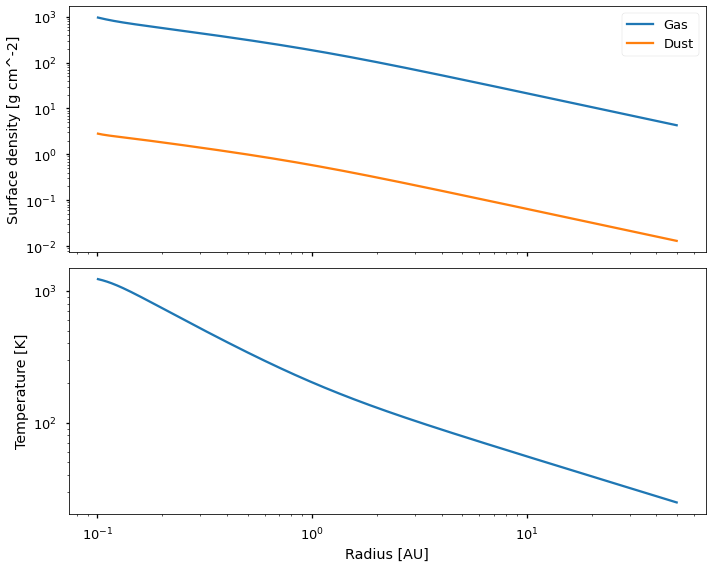

In [34]:

grid = Grid(0.1*Rau, 50*Rau, 512)

DM = DiscModel(grid, Mdot_gas, alpha, T, mu=mean_mol_wgt)

DM.compute_dust_surface_density(Mdot_gas*dust_flux_factor*dust_to_gas, Stokes)

f, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

ax[0].loglog(grid.Rc/Rau, DM.Sigma_gas, label='Gas')
ax[0].loglog(grid.Rc/Rau, DM.Sigma_dust, label='Dust')
ax[0].set_ylabel('Surface density [g cm^-2]')
ax[0].legend()

ax[1].loglog(grid.Rc/Rau, T(grid.Rc))
ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('Temperature [K]')
ax[0].legend()

f.tight_layout()

### Compute the chemical structure for drift

In [35]:
from drift_composition.molecule import get_molecular_properties

species, abundances = get_species_info(mol_abund)
DM.compute_chemistry(species, abundances, d2g=dust_to_gas)

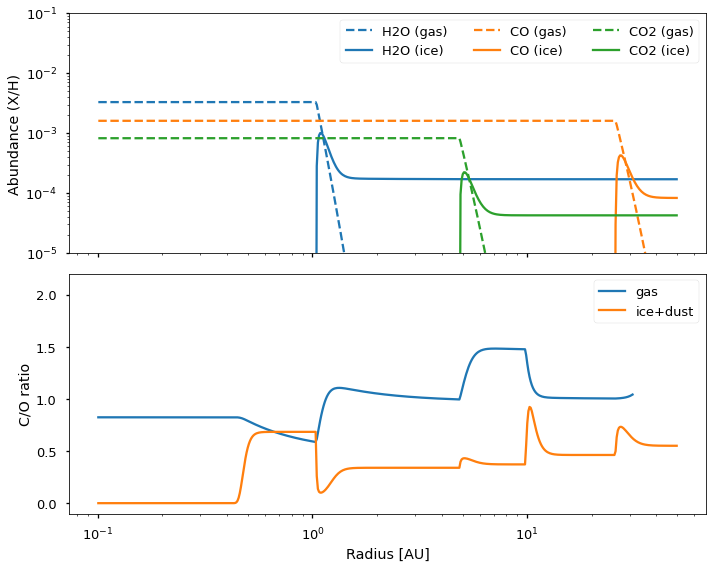

<Figure size 432x288 with 0 Axes>

In [36]:
columns = DM.compute_molecular_column()
f, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

idx = columns['CO'][:,0] > 0.5 * columns['CO'][:,1]


for spec in ['H2O', 'CO', 'CO2']:
    l,= ax[0].loglog(grid.Rc/Rau, 0.5*columns[spec][:,0]/columns['H2'][:,0], 
                     label=f'{spec} (gas)',  ls='--', )
    ax[0].loglog(grid.Rc/Rau, 0.5*columns[spec][:,1]/columns['H2'][:,0], 
                 label=f'{spec} (ice)',c=l.get_color())

ax[0].set_ylabel('Abundance (X/H)')
ax[0].legend(ncol=3)
ax[0].set_ylim(1e-5, 0.1)

columns = DM.compute_elemental_column(dust=grain_abund)
C2O = columns['C']/columns['O']

columns =  DM.compute_elemental_column() 
C2O_ice = columns['C']/columns['O']


plt.figure()
ax[1].semilogx(grid.Rc[idx]/Rau, C2O[idx,0], label='gas')
ax[1].semilogx(grid.Rc[:]/Rau, C2O[:,1], label='ice+dust')
#ax[1].semilogx(grid.Rc/Rau, C2O_ice[:,1], label='ice only')

ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('C/O ratio')
ax[1].set_ylim(-0.1, 2.2)
ax[1].legend()

f.tight_layout()

### Explore how the C/O ratio depends on dust composition

0
1
2


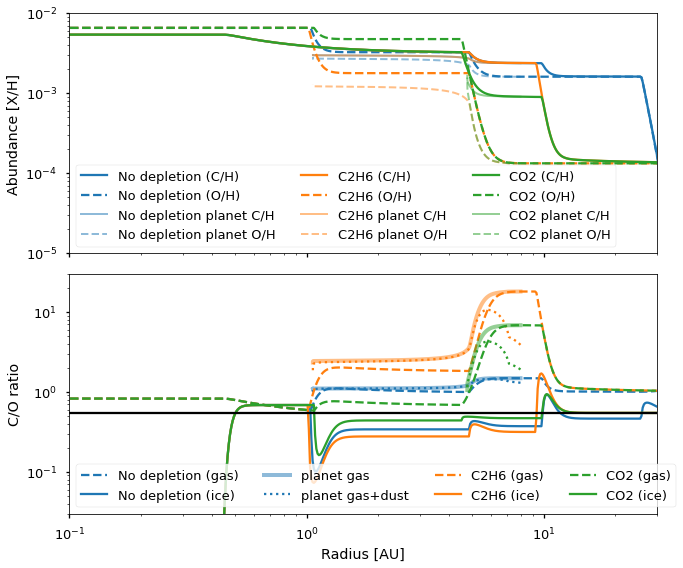

In [37]:
compositions = [[0, 'No depletion'], [0.9, 'C2H6'], [0.9, 'CO2']]#, [0.66, 'CH3OH']]
f, ax = plt.subplots(2, figsize=(10, 8), sharex=True)
for i, (fraction, mol) in enumerate(compositions):
    
    # Get the abundances
    if fraction > 0:
        abund = deplete_CO_abundance(mol_abund, fraction, mol)
    else:
        abund = mol_abund
    
    spec, abund = get_species_info(abund)

    # Run the model
    DM = DiscModel(grid, Mdot_gas, alpha, T, mu=mean_mol_wgt)
    DM.compute_dust_surface_density(Mdot_gas*dust_flux_factor*dust_to_gas, Stokes)
    DM.compute_chemistry(spec, abund, d2g=dust_to_gas)

    #initiallizing planet environment
    gas = {'H2':atom_abund['H']/2.,'He':atom_abund['He']}
    dust = grain_abund
    p_env = PlanetEnv(grid, alpha(grid.Rc), mean_mol_wgt, m_star, gas, dust) #create local disc properties

    #initializing the planets chemical composition
    f_comp = dict(zip([spec.name for spec in species],np.zeros((len(species),2))))
    for g in gas:
        f_comp[g] = np.zeros(2)
    for d in dust:
        f_comp[d] = np.zeros(2)

    mc = init_m*(1-frac_gc)
    mg = init_m*frac_gc
    planet_ini = Planet(init_m*Mearth/Msun, mc*Mearth/Msun, mg*Mearth/Msun, f_comp, init_r*Rau)
    planet_evo, nn = std_evo_comp(planet_ini, DM, p_env, T(grid.Rc),f_plansi, dt, Nt)
    e = Evolution(planet_evo, nn, dt) #rearrange the data for easy plotting
    
    #Plot the composition of the disc
    columns = DM.compute_elemental_column(dust=grain_abund)

    C2H = columns['C']/columns['H'][:,:1]
    O2H = columns['O']/columns['H'][:,:1]

    p, = ax[0].loglog(grid.Rc/Rau, C2H[:,0], label=mol + ' (C/H)')
    ax[0].loglog(grid.Rc/Rau, O2H[:,0], label=mol + ' (O/H)',  c=p.get_color(), ls='--')
    ax[0].plot(e.rs[1:], e.f_atms['C'][0][1:]/e.f_atms['H'][0][1:]*(1/12), 
               '-', lw=2, alpha=0.5, c=p.get_color(), label=mol+ ' planet C/H')
    ax[0].plot(e.rs[1:], e.f_atms['O'][0][1:]/e.f_atms['H'][0][1:]*(1/16), 
               '--', lw=2, alpha=0.5, c=p.get_color(), label=mol+ ' planet O/H')
    
    C2O = columns['C']/columns['O']
    l, = ax[1].loglog(grid.Rc/Rau, C2O[:,0], label=mol + ' (gas)', ls='--')
    ax[1].loglog(grid.Rc/Rau, C2O[:,1], label=mol + ' (ice)', c=l.get_color())
    
    #Plot the composition of the planet
    print(i)
    if i==0:
        ax[1].plot(e.rs[1:], e.f_atms['C'][0][1:]/e.f_atms['O'][0][1:]*(16/12), 
               '-', lw=4, alpha=0.5, c=l.get_color(), label='planet gas')
        ax[1].plot(e.rs[1:], 
               (e.f_atms['C'][0]+e.f_atms['C'][1])[1:]/(e.f_atms['O'][0]+e.f_atms['O'][1])[1:]*(16/12), 
               ':', c=l.get_color(), label='planet gas+dust')
    else:
        ax[1].plot(e.rs[1:], e.f_atms['C'][0][1:]/e.f_atms['O'][0][1:]*(16/12), 
               '-', lw=4, alpha=0.5, c=l.get_color())
        ax[1].plot(e.rs[1:], 
               (e.f_atms['C'][0]+e.f_atms['C'][1])[1:]/(e.f_atms['O'][0]+e.f_atms['O'][1])[1:]*(16/12), 
               ':', c=l.get_color())

ax[0].set_ylabel('Abundance [X/H]')
ax[0].legend(ncol=len(compositions))
ax[0].set_ylim(1e-5, 1e-2)

ax[1].set_xlabel('Radius [AU]')
ax[1].set_ylabel('C/O ratio')
ax[1].legend(ncol=4)
ax[1].set_ylim(3e-2, 30)
ax[1].set_xlim(1e-1, 30)


ax[1].axhline(atom_abund['C']/atom_abund['O'], c='k')

f.tight_layout()
    